In [55]:
import pandas as pd
import os
from transformers import pipeline
import spacy
from spacy.matcher import PhraseMatcher
import nltk
from nltk import ngrams
import string

In [56]:
'''
0.1 to 0.3: Low association
0.4 to 0.6: Moderate association
0.7 to 1.0: Strong association
'''
# data_collection/data/nhs/symptom_weights.json
symptom_df = pd.read_csv('../data_collection/data/nhs/symptom_weights.csv')
symptom_df.head()

,symptom,social phobia,general phobia,agoraphobia,claustrophobia,acrophobia,arachnophobia,aviophobia,aquaphobia,hemophobia,zoophobia
0,sweating,0.7,0.5,0.4,0.3,0.0,0.0,0.0,0.0,0.0,0.0
1,trembling,0.8,0.6,0.5,0.4,0.0,0.0,0.0,0.0,0.0,0.0
2,hot flushes or chills,0.5,0.6,0.4,0.3,0.0,0.0,0.0,0.0,0.0,0.0
3,shortness of breath,0.4,0.5,0.8,0.7,0.0,0.0,0.0,0.0,0.0,0.0
4,difficulty breathing,0.4,0.5,0.7,0.8,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
symptom_phrases = symptom_df['symptom'].tolist()  # Extract symptoms from DataFrame
symptom_phrases

['sweating',
 'trembling',
 'hot flushes or chills',
 'shortness of breath',
 'difficulty breathing',
 'choking sensation',
 'rapid heartbeat',
 'pain or tightness in the chest',
 'butterflies in the stomach',
 'nausea',
 'headaches and dizziness',
 'feeling faint',
 'numbness or pins and needles',
 'dry mouth',
 'need to go to the toilet',
 'ringing in your ears',
 'confusion or disorientation',
 'rapid breathing',
 'difficulty swallowing',
 'diarrhoea',
 'feeling sick',
 'chest pain',
 'dizziness',
 'feeling hot and sweaty',
 'blushing',
 'fear of losing control',
 'fear of fainting',
 'feelings of dread',
 'fear of dying',
 'fear of being unable to escape',
 'fear of being judged',
 'fear of social situations',
 'avoiding public spaces',
 'fear of enclosed spaces',
 'fear of heights',
 'fear of spiders',
 'fear of flying',
 'fear of water',
 'fear of crowds',
 'fear of blood',
 'fear of animals',
 'feeling detached from body',
 'pounding heartbeat',
 'panic attacks']

In [58]:
user_input = "I feel shortness of breath and have a choking sensation and headaches."

### Using Spacy PhraseMatcher to get list of symptoms

In [59]:
import spacy
spacy_model_base_path = spacy.util.get_package_path('en_core_web_sm')
subdir = 'en_core_web_sm-2.3.1'

# Join the paths
spacy_model_full_path = os.path.join(spacy_model_base_path, subdir)

# Print the result
print(spacy_model_full_path)


/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/en_core_web_sm/en_core_web_sm-2.3.1


In [60]:
def extract_symptoms_phraser(user_input):
    # Load Spacy model
    nlp = spacy.load(spacy_model_full_path)

    # Initialize PhraseMatcher and add patterns for multi-word symptoms
    matcher = PhraseMatcher(nlp.vocab)

    patterns = [nlp(symptom) for symptom in symptom_phrases]
    matcher.add("SYMPTOM", patterns)

    # Process user input
    doc = nlp(user_input)

    # Find matching symptoms in the user input
    matches = matcher(doc)
    extracted_symptoms_phraser = [doc[start:end].text for match_id, start, end in matches]

    print("Phrase Matched Symptoms:", extracted_symptoms_phraser)
    return list(set(extracted_symptoms_phraser))

### n-grams for Symptom Detection

In [61]:
def extract_symptoms_ngrams(user_input):
    # Preprocess the user input: convert to lowercase and remove punctuation
    user_input = user_input.lower()
    user_input = user_input.translate(str.maketrans('', '', string.punctuation))

    # Tokenize user input
    tokens = nltk.word_tokenize(user_input)

    # Generate bigrams and trigrams
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))

    # Convert n-grams back to phrases
    bigrams_phrases = [' '.join(gram) for gram in bigrams]
    trigrams_phrases = [' '.join(gram) for gram in trigrams]

    # Combine bigrams and trigrams
    all_ngrams = bigrams_phrases + trigrams_phrases

    # Match n-grams with symptom list (case-insensitive)
    extracted_symptoms_ngrams = [phrase for phrase in all_ngrams if phrase in symptom_phrases]

    print("n-gram Matched Symptoms:", extracted_symptoms_ngrams)
    return list(set(extracted_symptoms_ngrams))


## Dependency Parsing for Symptom Detection

In [62]:

# Function to extract symptoms based on dependencies
def extract_symptoms_doc(user_input):
    # Load Spacy model
    nlp = spacy.load(spacy_model_full_path)

    # Process user input
    doc = nlp(user_input)
    
    # Loop through tokens and print dependencies
    # for token in doc:
    #     print(f"Token: {token.text}, Dependency: {token.dep_}, Head: {token.head.text}, Children: {[child.text for child in token.children]}")
    
    
    symptoms = []
    for token in doc:
        # Check for "amod" + "dobj" (e.g., "choking sensation")
        if token.dep_ == "amod" and token.head.dep_ == "dobj":
            symptom = f"{token.text} {token.head.text}"
            symptoms.append(symptom)
        
        # Check for "attr" + "prep" + "pobj" (e.g., "shortness of breath")
        if token.dep_ == "attr" and len([child for child in token.children if child.dep_ == "prep"]) > 0:
            prep = [child for child in token.children if child.dep_ == "prep"][0]
            pobj = [child for child in prep.children if child.dep_ == "pobj"][0]
            symptom = f"{token.text} {prep.text} {pobj.text}"
            symptoms.append(symptom)
        
        # Check for "dobj" conjunction (e.g., "headaches and dizziness")
        if token.dep_ == "dobj" and len([child for child in token.children if child.dep_ == "conj"]) > 0:
            conj = [child for child in token.children if child.dep_ == "conj"][0]
            symptom = f"{token.text} and {conj.text}"
            symptoms.append(symptom)
        
    return symptoms

# Extract symptoms from the doc
# extracted_symptoms_doc = list(set(extract_symptoms_doc(user_input)))
# print("Extracted Symptoms from doc:", extracted_symptoms_doc)

### Using BioBERT and Fuzzywuzzy for Symptom detection

In [73]:
from transformers import BertTokenizer, BertForTokenClassification, pipeline
from fuzzywuzzy import process

def extract_symptoms_biobert(user_input):
    # Load the pre-trained BioBERT model for NER
    model_name = "dmis-lab/biobert-base-cased-v1.1"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForTokenClassification.from_pretrained(model_name)

    # Use the pipeline for named entity recognition (NER)
    ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

    # Function to match extracted symptoms with the known symptom list using fuzzy matching
    def match_symptom(extracted_entity, symptom_phrases, threshold=90):
        match, score = process.extractOne(extracted_entity, symptom_phrases)
        if score >= threshold:
            return match
        return None

    # Perform Named Entity Recognition (NER) to extract potential symptoms
    entities = ner_pipeline(user_input)

    # Extract entities from the NER results
    extracted_entities = [entity['word'].lower() for entity in entities]

    # Match each extracted entity with the known symptom list
    extracted_symptoms_bert = [match_symptom(entity, symptom_phrases) for entity in extracted_entities if match_symptom(entity, symptom_phrases)]

    print("Matched Symptoms BERT and fuzzywuzzy:", set(extracted_symptoms_bert))
    return list(set(extracted_symptoms_bert))


### Combined list of Symptoms

In [74]:
def get_all_combined_symptoms(user_input):
    combined_symptoms = extract_symptoms_phraser(user_input) + extract_symptoms_ngrams(user_input) + extract_symptoms_doc(user_input) + extract_symptoms_biobert(user_input)
    combined_symptoms = list(set(combined_symptoms))
    return combined_symptoms
get_all_combined_symptoms(user_input)

Phrase Matched Symptoms: ['shortness of breath', 'choking sensation']
n-gram Matched Symptoms: ['choking sensation', 'shortness of breath']


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Matched Symptoms BERT and fuzzywuzzy: {'choking sensation', 'headaches and dizziness', 'sweating', 'fear of fainting', 'feeling faint', 'shortness of breath'}


['sensation and headaches',
 'choking sensation',
 'headaches and dizziness',
 'sweating',
 'fear of fainting',
 'feeling faint',
 'shortness of breath']

In [75]:
get_all_combined_symptoms("Having trouble breathing")

Phrase Matched Symptoms: []
n-gram Matched Symptoms: []


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Matched Symptoms BERT and fuzzywuzzy: {'difficulty breathing'}


['difficulty breathing']

# Model Creation

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, LeaveOneOut, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [14]:
# Preprocess the data
X = symptom_df.drop(columns=['symptom'])  # Features
y = X.idxmax(axis=1)

# Initialize the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()

# Fit and predict using LOOCV
y_pred_dt = cross_val_predict(decision_tree_model, X, y, cv=loo)

# Calculate metrics
dt_accuracy = accuracy_score(y, y_pred_dt)
dt_classification_report = classification_report(y, y_pred_dt)

# Results
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Decision Tree Classification Report: \n{dt_classification_report}")

Decision Tree Accuracy: 0.7272727272727273
Decision Tree Classification Report: 
                precision    recall  f1-score   support

    acrophobia       0.00      0.00      0.00         1
   agoraphobia       0.83      0.91      0.87        11
    aquaphobia       0.00      0.00      0.00         1
 arachnophobia       0.00      0.00      0.00         1
    aviophobia       0.00      0.00      0.00         1
claustrophobia       0.89      0.80      0.84        10
general phobia       1.00      0.80      0.89         5
    hemophobia       0.00      0.00      0.00         1
 social phobia       0.77      0.83      0.80        12
     zoophobia       0.00      0.00      0.00         1

      accuracy                           0.73        44
     macro avg       0.35      0.33      0.34        44
  weighted avg       0.73      0.73      0.73        44



/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [15]:
# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)

# Fit and predict using LOOCV
y_pred_knn = cross_val_predict(knn_model, X, y, cv=loo)

# Calculate metrics
knn_accuracy = accuracy_score(y, y_pred_knn)
knn_classification_report = classification_report(y, y_pred_knn)

# Results
print(f"KNN Accuracy: {knn_accuracy}")
print(f"KNN Classification Report: \n{knn_classification_report}")


KNN Accuracy: 0.7727272727272727
KNN Classification Report: 
                precision    recall  f1-score   support

    acrophobia       0.00      0.00      0.00         1
   agoraphobia       0.60      0.82      0.69        11
    aquaphobia       0.00      0.00      0.00         1
 arachnophobia       0.00      0.00      0.00         1
    aviophobia       0.00      0.00      0.00         1
claustrophobia       0.82      0.90      0.86        10
general phobia       0.80      0.80      0.80         5
    hemophobia       0.00      0.00      0.00         1
 social phobia       0.92      1.00      0.96        12
     zoophobia       0.00      0.00      0.00         1

      accuracy                           0.77        44
     macro avg       0.31      0.35      0.33        44
  weighted avg       0.68      0.77      0.72        44



/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [16]:
# Initialize the Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000)

# Fit and predict using LOOCV
y_pred_lr = cross_val_predict(logistic_regression_model, X, y, cv=loo)

# Calculate metrics
lr_accuracy = accuracy_score(y, y_pred_lr)
lr_classification_report = classification_report(y, y_pred_lr)

# Results
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Logistic Regression Classification Report: \n{lr_classification_report}")


Logistic Regression Accuracy: 0.7045454545454546
Logistic Regression Classification Report: 
                precision    recall  f1-score   support

    acrophobia       0.00      0.00      0.00         1
   agoraphobia       0.60      0.82      0.69        11
    aquaphobia       0.00      0.00      0.00         1
 arachnophobia       0.00      0.00      0.00         1
    aviophobia       0.00      0.00      0.00         1
claustrophobia       0.67      1.00      0.80        10
general phobia       0.00      0.00      0.00         5
    hemophobia       0.00      0.00      0.00         1
 social phobia       0.86      1.00      0.92        12
     zoophobia       0.00      0.00      0.00         1

      accuracy                           0.70        44
     macro avg       0.21      0.28      0.24        44
  weighted avg       0.54      0.70      0.61        44



/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [17]:
# Initialize the Naive Bayes model
naive_bayes_model = MultinomialNB()

# Fit and predict using LOOCV
y_pred_nb = cross_val_predict(naive_bayes_model, X, y, cv=loo)

# Calculate metrics
nb_accuracy = accuracy_score(y, y_pred_nb)
nb_classification_report = classification_report(y, y_pred_nb)

# Results
print(f"Naive Bayes Accuracy: {nb_accuracy}")
print(f"Naive Bayes Classification Report: \n{nb_classification_report}")


Naive Bayes Accuracy: 0.6363636363636364
Naive Bayes Classification Report: 
                precision    recall  f1-score   support

    acrophobia       0.00      0.00      0.00         1
   agoraphobia       0.54      0.64      0.58        11
    aquaphobia       0.00      0.00      0.00         1
 arachnophobia       0.00      0.00      0.00         1
    aviophobia       0.00      0.00      0.00         1
claustrophobia       0.75      0.90      0.82        10
general phobia       0.00      0.00      0.00         5
    hemophobia       0.00      0.00      0.00         1
 social phobia       0.63      1.00      0.77        12
     zoophobia       0.00      0.00      0.00         1

      accuracy                           0.64        44
     macro avg       0.19      0.25      0.22        44
  weighted avg       0.48      0.64      0.54        44



/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [18]:
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"KNN Accuracy: {knn_accuracy}")
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Naive Bayes Accuracy: {nb_accuracy}")


Decision Tree Accuracy: 0.7272727272727273
KNN Accuracy: 0.7727272727272727
Logistic Regression Accuracy: 0.7045454545454546
Naive Bayes Accuracy: 0.6363636363636364


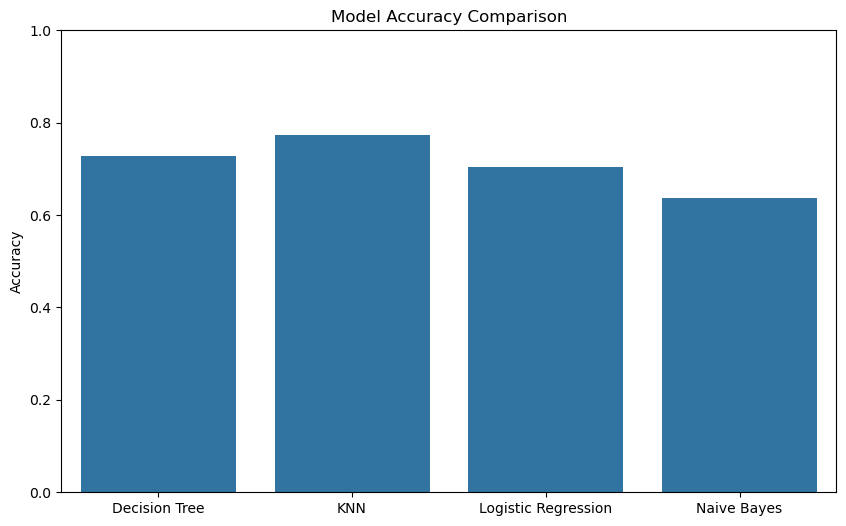

In [19]:
# Placeholder accuracy values for each model (replace these with actual accuracy scores)
model_names = ['Decision Tree', 'KNN', 'Logistic Regression', 'Naive Bayes']
accuracies = [dt_accuracy, knn_accuracy, lr_accuracy, nb_accuracy]

# Bar Plot for Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for easier interpretation
plt.show()


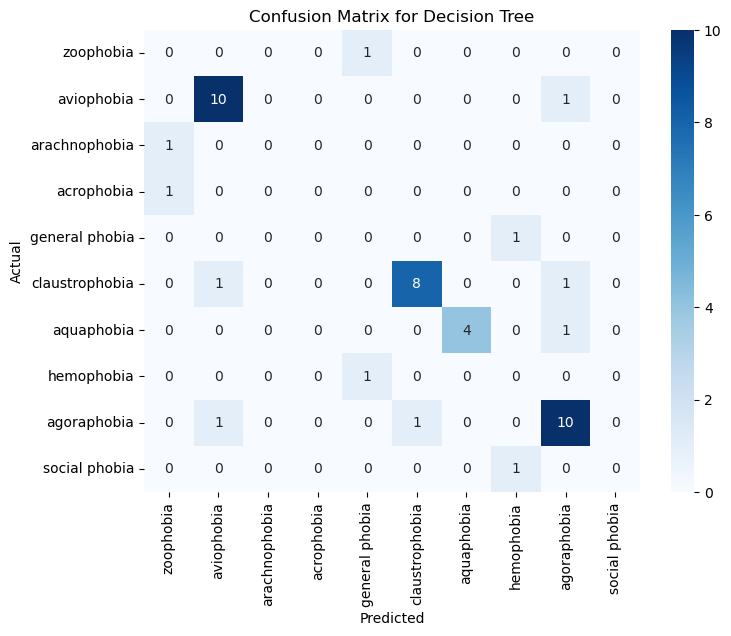

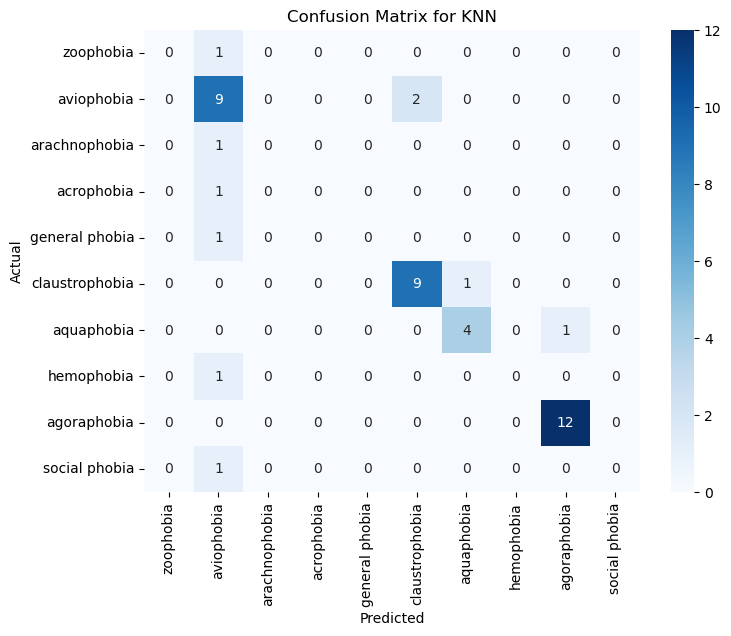

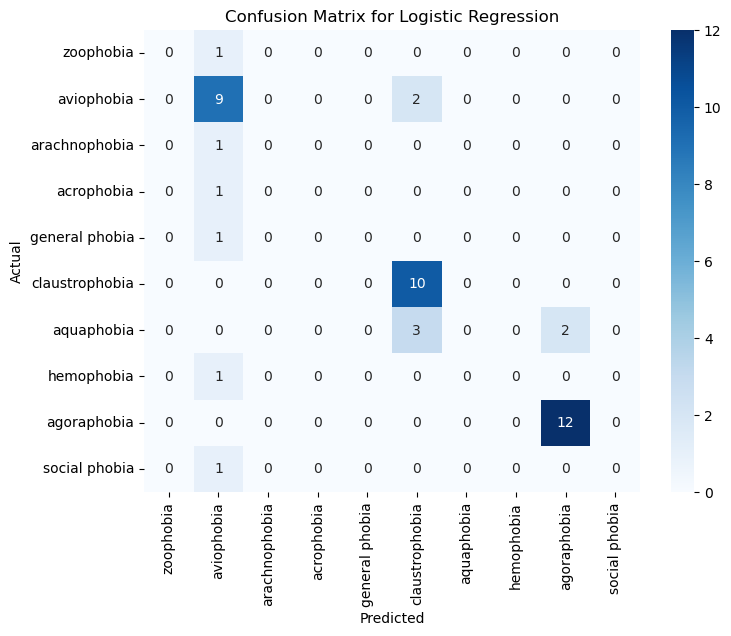

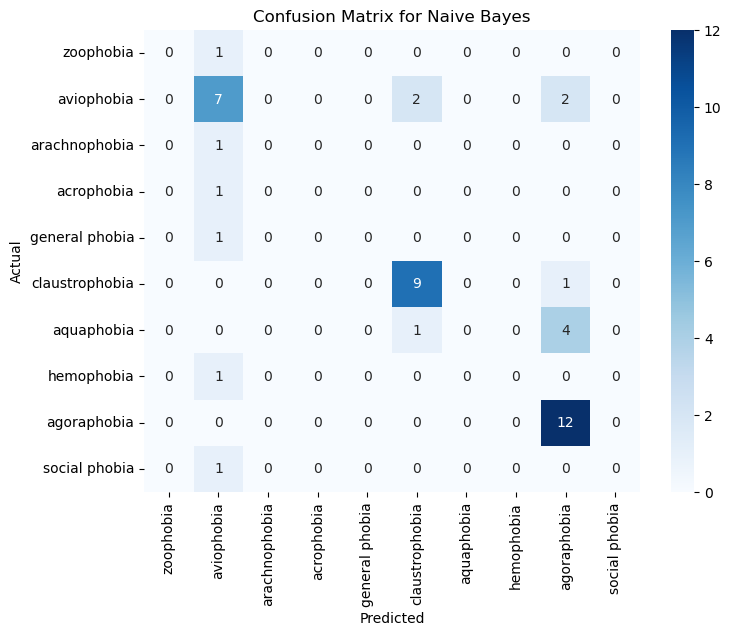

In [20]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y), yticklabels=set(y))
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix(y, y_pred_dt, 'Decision Tree')
plot_confusion_matrix(y, y_pred_knn, 'KNN')
plot_confusion_matrix(y, y_pred_lr, 'Logistic Regression')
plot_confusion_matrix(y, y_pred_nb, 'Naive Bayes')


## Model Tuning

#### Grid Search for KNN

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define hyperparameter grid for KNN
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9]  # Different numbers of neighbors
}

# Initialize KNN model
knn_model = KNeighborsClassifier()

# Grid Search with Cross-Validation
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='accuracy')

# Fit the model to find the best hyperparameters
grid_search_knn.fit(X, y)

# Best parameters and the corresponding accuracy
best_knn_params = grid_search_knn.best_params_
best_knn_score = grid_search_knn.best_score_

print(f"Best KNN Params: {best_knn_params}")
print(f"Best KNN Accuracy: {best_knn_score}")


Best KNN Params: {'n_neighbors': 3}
Best KNN Accuracy: 0.7722222222222221


/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


#### Grid Search for Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100]  # Regularization strength
}

# Initialize Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000)

# Grid Search with Cross-Validation
grid_search_lr = GridSearchCV(logistic_regression_model, param_grid_lr, cv=5, scoring='accuracy')

# Fit the model to find the best hyperparameters
grid_search_lr.fit(X, y)

# Best parameters and the corresponding accuracy
best_lr_params = grid_search_lr.best_params_
best_lr_score = grid_search_lr.best_score_

print(f"Best Logistic Regression Params: {best_lr_params}")
print(f"Best Logistic Regression Accuracy: {best_lr_score}")


/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Logistic Regression Params: {'C': 100}
Best Logistic Regression Accuracy: 0.7972222222222222


#### Grid Search for Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Define hyperparameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Grid Search with Cross-Validation
grid_search_dt = GridSearchCV(decision_tree_model, param_grid_dt, cv=5, scoring='accuracy')

# Fit the model to find the best hyperparameters
grid_search_dt.fit(X, y)

# Best parameters and the corresponding accuracy
best_dt_params = grid_search_dt.best_params_
best_dt_score = grid_search_dt.best_score_

print(f"Best Decision Tree Params: {best_dt_params}")
print(f"Best Decision Tree Accuracy: {best_dt_score}")


/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Decision Tree Params: {'max_depth': None, 'min_samples_split': 2}
Best Decision Tree Accuracy: 0.7222222222222221


### Compare the Best Models

In [24]:
# Display results for all models
print(f"Best KNN Params: {best_knn_params}, Accuracy: {best_knn_score}")
print(f"Best Logistic Regression Params: {best_lr_params}, Accuracy: {best_lr_score}")
print(f"Best Decision Tree Params: {best_dt_params}, Accuracy: {best_dt_score}")


Best KNN Params: {'n_neighbors': 3}, Accuracy: 0.7722222222222221
Best Logistic Regression Params: {'C': 100}, Accuracy: 0.7972222222222222
Best Decision Tree Params: {'max_depth': None, 'min_samples_split': 2}, Accuracy: 0.7222222222222221


## Predict Phobia

In [25]:
def symptom_to_features(symptom_list, dataset):
    """
    Convert a list of symptoms to the corresponding feature vector using the dataset.
    Input: List of symptoms, dataset (uploaded_symptom_weights_df)
    Output: A feature vector corresponding to the symptoms
    """
    feature_vector = [0] * len(dataset.columns[1:])  # Initialize a zero vector for all phobias
    for symptom in symptom_list:
        if symptom in dataset['symptom'].values:
            symptom_data = dataset[dataset['symptom'] == symptom].iloc[0, 1:].values
            feature_vector = [max(f, s) for f, s in zip(feature_vector, symptom_data)]  # Max of both vectors
    return feature_vector


In [26]:
def predict_phobia(symptom_list, models, dataset):
    """
    Predict phobia based on symptoms using the provided models (KNN, Logistic Regression, Decision Tree).
    Input: List of symptoms, trained models (dictionary), dataset
    Output: Predictions from each model
    """
    # Convert symptoms to feature vector
    features = [symptom_to_features(symptom_list, dataset)]
    
    # Dictionary to store results from each model
    predictions = {}
    
    # Predict using KNN
    predictions['KNN'] = models['KNN'].predict(features)
    
    # Predict using Logistic Regression
    predictions['Logistic Regression'] = models['Logistic Regression'].predict(features)
    
    # Predict using Decision Tree
    predictions['Decision Tree'] = models['Decision Tree'].predict(features)
    
    return predictions


In [27]:
# Assuming models are already trained and stored
models = {
    'KNN':grid_search_knn,  # The trained KNN model
    'Logistic Regression': grid_search_lr,  # The trained Logistic Regression model
    'Decision Tree': grid_search_dt  # The trained Decision Tree model
}

# Example symptoms provided by the user
user_symptoms = get_all_combined_symptoms(user_input)

# Predict phobia based on symptoms
predictions = predict_phobia(user_symptoms, models, symptom_df)

# Display the predictions
for model, prediction in predictions.items():
    print(f"{model} predicts: {prediction[0]}")


Phrase Matched Symptoms: ['shortness of breath', 'choking sensation']
n-gram Matched Symptoms: ['choking sensation', 'shortness of breath']


/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Matched Symptoms BERT and fuzzywuzzy: {'choking sensation', 'headaches and dizziness', 'sweating', 'fear of fainting', 'feeling faint', 'shortness of breath'}
KNN predicts: claustrophobia
Logistic Regression predicts: claustrophobia
Decision Tree predicts: agoraphobia


/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [29]:
import joblib

# Save each of the trained models
joblib.dump(grid_search_knn, '../models/best_knn_model.pkl')
joblib.dump(grid_search_lr, '../models/best_lr_model.pkl')
joblib.dump(grid_search_dt, '../models/best_dt_model.pkl')


['../models/best_dt_model.pkl']

In [30]:
from collections import Counter

def majority_voting(predictions):
    """
    Use majority voting to select the final predicted phobia.
    Input: Predictions from different models
    Output: Final predicted phobia based on majority voting
    """
    votes = [prediction[0] for prediction in predictions.values()]  # Collect all model predictions
    vote_count = Counter(votes)  # Count the occurrences of each predicted phobia
    final_prediction = vote_count.most_common(1)[0][0]  # Select the most common prediction
    return final_prediction

# Example usage
final_prediction = majority_voting(predictions)
print(f"Final predicted phobia based on majority voting: {final_prediction}")


Final predicted phobia based on majority voting: claustrophobia


In [95]:
# Load the CSV file into a DataFrame
df_intents = pd.read_csv("../data_collection/data/intent.csv")

# Convert the phrases and intents into lists for easy matching
phrases = df_intents["Word"].tolist()
intents = df_intents["Intent"].tolist()


def get_intent(user_input):
    # Find the closest matching phrase and its score
    match, score = process.extractOne(user_input, phrases)
    print(match, score)
    
    # Set a threshold for how close the match needs to be
    threshold = 90
    
    # If the match score is above the threshold, return the corresponding intent
    if score > threshold:
        intent_index = phrases.index(match)
        return intents[intent_index]
    else:
        # If no good match is found, return "symptoms" as default intent
        return "symptoms"


In [96]:
import random
# Personalized greeting responses
def personalized_greeting():
    responses = [
        "Hello! How can I assist you today?",
        "Hi there! What can I do for you?",
        "Hey! How are you feeling today?",
        "Good to see you! How can I help?"
    ]
    return random.choice(responses)

# Friendly goodbye responses
def friendly_goodbye():
    responses = [
        "Goodbye! Take care, and don't hesitate to reach out if you need help.",
        "Bye! Have a great day ahead!",
        "See you later! Stay safe.",
        "Goodbye! I'm here if you need anything."
    ]
    return random.choice(responses)

# No symptoms confirmation
def no_symptoms_response():
    responses = [
        "Glad to hear you're feeling well! Is there anything else I can help you with?",
        "That's great! Let me know if there's anything else you need assistance with.",
        "Awesome! If you ever need help, feel free to reach out.",
        "Wonderful to hear you're in good health. Is there anything else on your mind?"
    ]
    return random.choice(responses)

# Empathetic response for symptoms
def empathetic_symptom_response(symptoms):
    if symptoms:
        return f"It sounds like you're experiencing {', '.join(symptoms)}. I'm sorry to hear that. Can you tell me more about how long you've been feeling this way?"
    else:
        return "I understand you're not feeling well. Could you describe your symptoms in more detail?"

# Ask for clarification if the intent is unknown or unclear
def ask_for_clarification():
    responses = [
        "I'm not sure I understood that. Could you please rephrase?",
        "Can you clarify what you're asking about?",
        "I didn't catch that. Could you provide more details?",
        "Sorry, I didn’t quite get that. Can you try again?"
    ]
    return random.choice(responses)

# Main function to handle user input and return a response
def handle_input(user_input):
    intent = get_intent(user_input)
    print(intent)
    
    if intent == "greeting":
        return personalized_greeting()
    elif intent == "goodbye":
        return friendly_goodbye()
    elif intent == "no_symptoms":
        return no_symptoms_response()
    elif intent == "symptoms":
        symptoms = get_all_combined_symptoms(user_input)
        return empathetic_symptom_response(symptoms)
    else:
        return ask_for_clarification()

# Example interaction
user_input = "I'm feeling a bit dizzy and my heart is racing."
response = handle_input(user_input)
print(response)

have a nice day 86
symptoms
Phrase Matched Symptoms: []
n-gram Matched Symptoms: []


/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Matched Symptoms BERT and fuzzywuzzy: {'feeling faint', 'headaches and dizziness', 'sweating', 'rapid heartbeat'}
It sounds like you're experiencing feeling faint, headaches and dizziness, sweating, rapid heartbeat. I'm sorry to hear that. Can you tell me more about how long you've been feeling this way?


In [88]:
# Example input
user_input = "I'm feeling a bit dizzy and I have a rapid heartbeat."
response = handle_input(user_input)
print(response)


have a nice day 86
symptoms
Phrase Matched Symptoms: ['rapid heartbeat']
n-gram Matched Symptoms: ['rapid heartbeat']


/Users/piyush/opt/anaconda3/envs/env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Matched Symptoms BERT and fuzzywuzzy: {'feeling faint', 'headaches and dizziness', 'sweating', 'rapid heartbeat'}
I detected the following symptoms: feeling faint, headaches and dizziness, sweating, rapid heartbeat


hello 100
greeting
Hello! How can I assist you?
